# Interpretability of a linear regression model

Interpret means to "explain" or to present in understandable terms. The ability to express in understandable terms, what the 
model has learned and the reasons that affect their output.

Interpretability is about the extent to which a cause and effect can be observed within a system. Or to put it another way, it is the extent to which you are able to predict what is going to happen, given a change in input or algorithmic parameters. It's being able to understand which inputs are the most predictive (i.e., impact the prediction/output the most), and anticipate how predictions will change with differing inputs.

* If a customer is rejected a loan, we can say why
* If an insurance provides a certain premium, we know the reasons.
* If we diagnose a patient with a certain disease, we can tell them why

## Fit an interpretable linear regression model and make global and local interpretations

The idea is to fit an interpretable linear regression model, evaluate the model fit and the coefficients, and then interpret the predictions globally and locally.

In this example, we will use the shrinkage method and variable selection for linear regression models (called lasso regression) is another regularized version of linear regression.

An important peculiarity of lasso regression is that it tends to suppress the weights of less important features (i.e., set them to zero). Roughly speaking, lasso regression automatically performs feature selection and outputs a sparse model (i.e., with few non-zero feature weights).

The workflow is the following:

- Make some data engineer to prepare the data
- Exploratory data analysis and identify multi-colinearity
- Fit a linear model with the highest performance and least number of features
- Evaluate the model fit
- Evaluate the coefficients (global interpretation)
- Evaluate a few observations individually (local interpretation)

In [26]:
# imports
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10000)
# pd.set_option('display.max_rows', 10000)
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from itertools import product
from scipy import stats
import statsmodels.api as sm

import scipy.stats as ss
from scipy.stats.contingency import association
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split

In [3]:
# load dataset
train_set = pd.read_csv('datasets/house_price_train.csv')
train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Exploratory data analysis

This topic we gonna work in an exploration to see what we should do with this data to be able to go to the next steps, readers can skip this step if you are interested just in the model interpretation step.

[Link to the dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

Obs: we don't gonna make an extensive and deep exploratory, because the goal of this notebook is to show how to interpret the models, but in a real project, you should go deeper in the exploration and extract many information as possible.

### Univariate data analysis

For this step, we gonna use a very nice tool to make the things faster that is [sweetviz](https://pypi.org/project/sweetviz/) tool. If you don't know the tool, have a look in the documentation!

In [3]:
# general informations about the dataset
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
my_report = sv.analyze(train_set, 'SalePrice')
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

Feature: SalePrice (TARGET)                  |          | [  1%]   00:00 -> (00:02 left)

Feature: MSZoning                            |▍         | [  5%]   00:02 -> (00:45 left)

### Bivariate Data Analysis

Here we will deal with the descriptive analysis of the **association** between two variables. **In general, we say that there is an association between two variables if knowledge of the value of one of them gives us some information about some characteristic of the distribution (of frequencies) of the other.**

*We can highlight three cases:*

1. both variables are qualitative.
2. both variables are quantitative.
3. one variable is qualitative and the other is quantitative.

#### Two qualitative variables and evaluate multicollinearity

Here the idea is to check the correlation between two qualitative variables.

What are the consequences of multicollinearity?

If two variables are perfectly collinear, in other words, if they have correlation coefficient equal to 1, then what happens is that there is an infinite combination of coefficients (betas) that would work equally well. So basically we have an infinite number of linear regression models that will predict equally well the target from these two perfectly collinear variables. Which means that we are not able to understand what is the real relationship between those variables and the target.

* Perfect collinearity is rare
* Partial collinearity is unavoidable

So what happens is that when we have correlated variables, one of the therms (feature x coefficient) will account for a degree of the variability, and then the other therm basically accounts for the remaining variability that is not explained, but in both cases the coefficient doesn't really represent the real if you want association between the variable and the target.

In [4]:
# filter the qualitative variables
qualitative_features_enconding = [
    'MSZoning', 'Street', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Foundation', 'Heating', 'CentralAir', 'Functional',
    'PavedDrive', 'SaleType', 'SaleCondition']

qualitative_features_missing_mode = [
    'Electrical', 'GarageType']

ordinal_features_quality = [
    'ExterQual', 'ExterCond', 
    'BsmtQual', 'BsmtCond',
    'HeatingQC', 'KitchenQual',
    'GarageQual', 'GarageCond']

ordinal_features_exposure = ['BsmtExposure']

ordinal_features_finish = ['BsmtFinType1', 'BsmtFinType2']

ordinal_features_garage = ['GarageFinish']

qualitative_vars = qualitative_features_enconding + qualitative_features_missing_mode + ordinal_features_quality + ordinal_features_exposure + ordinal_features_finish + ordinal_features_garage

In [5]:
# create a dataframe with only categorical variables
categorical_df = train_set[qualitative_vars]

# removing records with at least one null value in a row
df_cat_v1 = categorical_df.dropna()

## let us split this list into two parts
cat_var1 = qualitative_vars
cat_var2 = qualitative_vars

# let us jump to Chi-Square test
# creating all possible combinations between the above two variables list
cat_var_prod = list(product(cat_var1, cat_var2, repeat = 1))

# creating an empty variable and picking only the p value from the output of Chi-Square test
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        contingency_table = pd.crosstab(df_cat_v1[i[0]], df_cat_v1[i[1]])
        chi2_pval = ss.chi2_contingency(contingency_table)[1]
        tschuprow_pval = association(contingency_table, method='tschuprow')
        result.append((i[0], i[1], chi2_pval, tschuprow_pval))

# Creating dataframe
result_df = pd.DataFrame(result, columns=['Variable_1', 'Variable_2', 'Chi2_P_Value', 'Tschuprow'])

# let's filter the values with tschuprow coefficient higher than 0.7 to catch multicollinearity
result_df.loc[(result_df['Tschuprow'] >= 0.7)]

,Variable_1,Variable_2,Chi2_P_Value,Tschuprow
518,Exterior1st,Exterior2nd,0.0,0.744531
554,Exterior2nd,Exterior1st,0.0,0.744531


Maybe we can remove one of these two features, the one that has less correlation with the target is a good choice.

#### Two quantitative variables and evaluate multicollinearity

Here the idea is to check the correlation between two quantitative variables and check multicollinearity.

In [6]:
# select features according to their types and missing values
quantitative_features = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
                         'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                         'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                         'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                         'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                         'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                         'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                         'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

quantitative_features_missing_median = ['LotFrontage', 'MasVnrArea']

quantitative_features_missing_mode = ['LotFrontage', 'YearRemodAdd', 'GarageYrBlt']

quantitative_vars = quantitative_features + quantitative_features_missing_median + quantitative_features_missing_mode

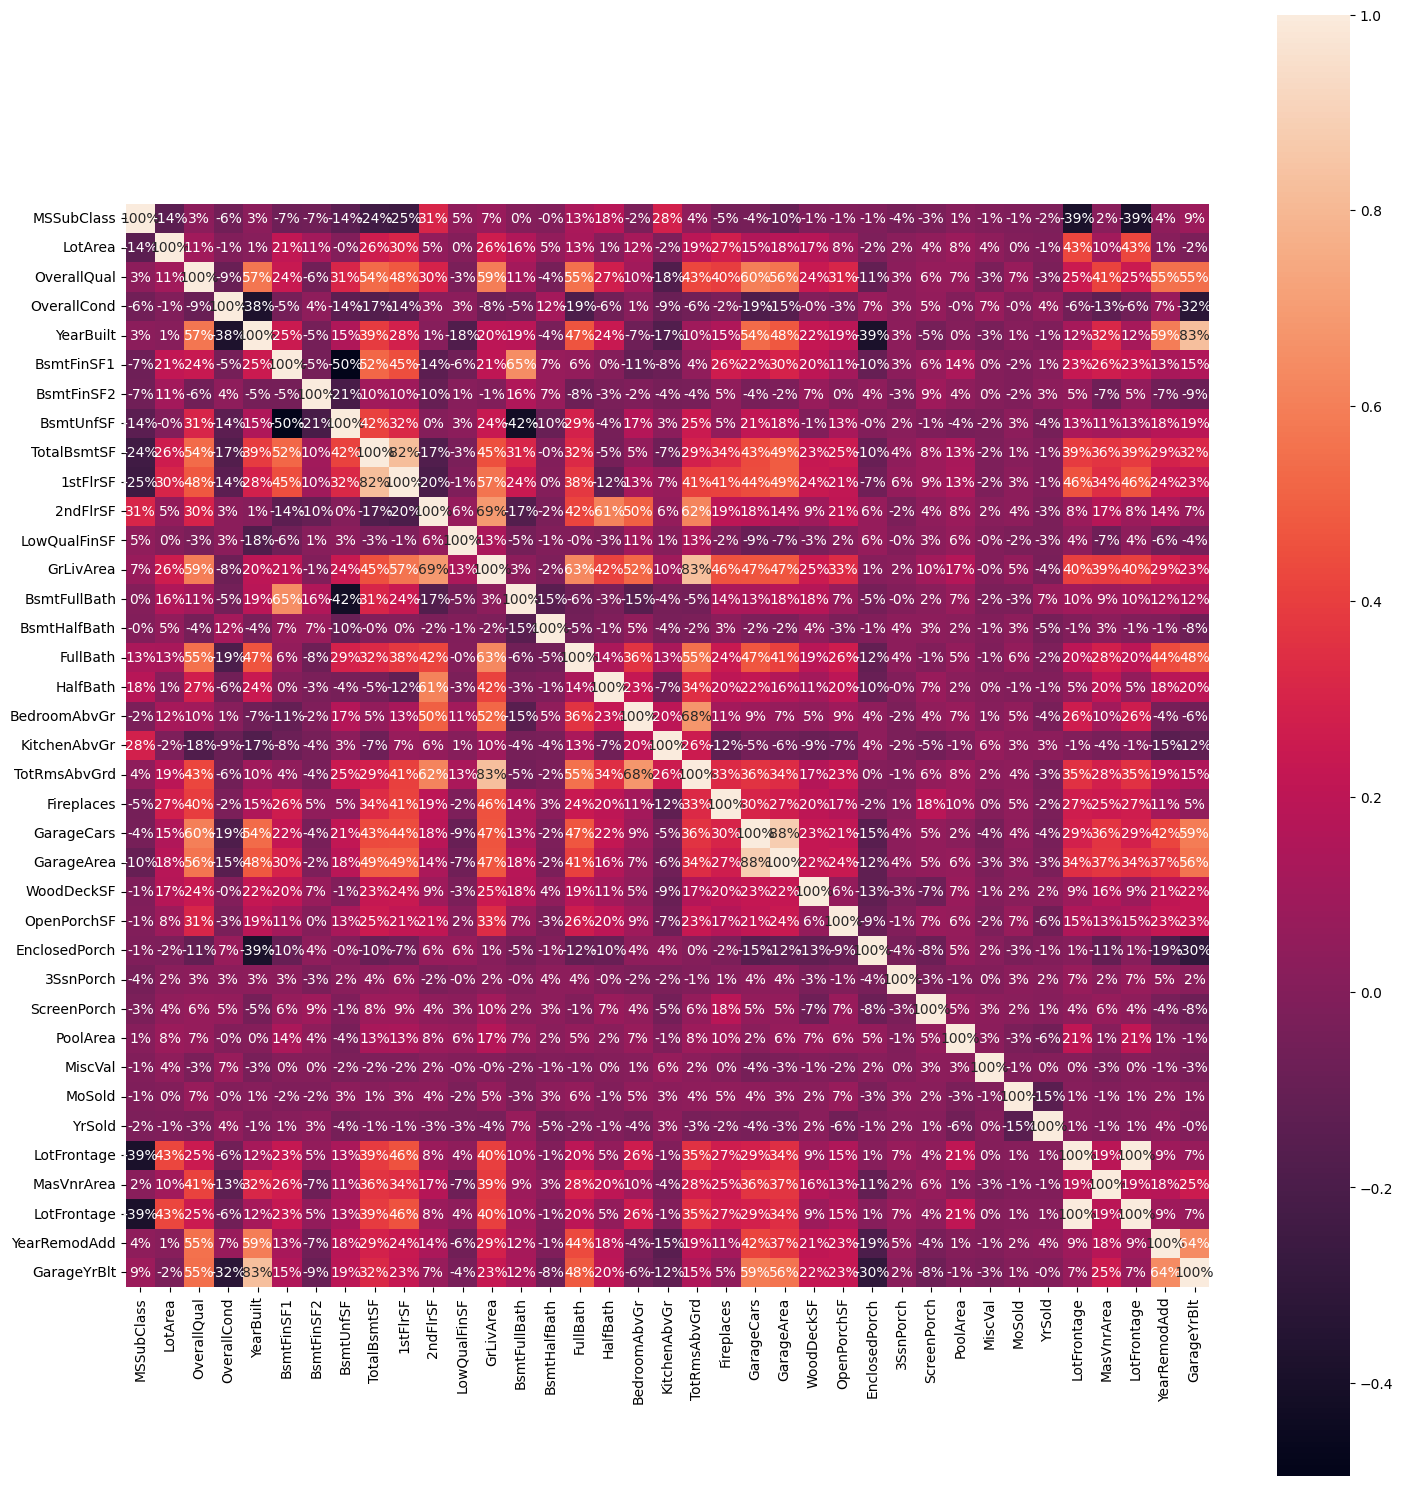

In [7]:
# quantitative associations
quantitative_df = train_set[quantitative_vars]
corr = quantitative_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, fmt='.0%', annot=True, square=True)
plt.tight_layout()

From the Pearson correlation, few variables appeared to be highly correlated. Let's check this collinearity with the VIF metric and that could possibly be an indication for feature selection.

The second metric for gauging multicollinearity is the variance inflation factor (VIF). The VIF directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question.

In layman’s terms, it gauges how much a feature’s inclusion contributes to the overall variance of the coefficients of the features in the model.

A VIF of 1 indicates that the feature has no correlation with any of the other features.

Typically, a VIF value exceeding 5 or 10 is deemed to be too high. Any feature with such VIF values is likely to be contributing to multicollinearity.

In [8]:
# Compute VIF data for each independent variable
clean_quantitative_df = quantitative_df.dropna()
vif = pd.DataFrame()
vif["features"] = clean_quantitative_df.columns
vif["vif_Factor"] = [variance_inflation_factor(clean_quantitative_df.values, i) for i in range(clean_quantitative_df.shape[1])]
vif.sort_values(by=['vif_Factor'], ascending=False, inplace=True)
vif

,features,vif_Factor
8,TotalBsmtSF,inf
10,2ndFlrSF,inf
32,LotFrontage,inf
34,LotFrontage,inf
12,GrLivArea,inf
5,BsmtFinSF1,inf
6,BsmtFinSF2,inf
7,BsmtUnfSF,inf
11,LowQualFinSF,inf
9,1stFlrSF,inf


We see that a lot of variables have a high VIF and therefore, it may be variables to eliminate in the modeling that we will do later.

#### One qualitative and one quantitative variable

Here the idea is to check the correlation between the qualitative and quantitative variable (the target) to see if the qualitative variables have a high influence in the target, but for this project we gonna skip this part, but in your project you should go deeper.

## Preprocessing

Based on what we have seen in exploratory data analysis, we gonna make some transformations in the data to be able to fit them in the linear regression model.

In [9]:
# select only the features that we are going to use
X = train_set.drop(['SalePrice'], axis=1)
y = train_set['SalePrice']

In [10]:
class QualMapper(BaseEstimator, TransformerMixin):
    def __init__(self, qual_vars):
        self.qual_vars = qual_vars

    def fit(self, X, y=None):
        return self  # no need to do anything here

    def transform(self, X):
        def map_quality(entry):
            if entry == 'Po':
                return 1
            elif entry == 'Fa':
                return 2
            elif entry == 'TA':
                return 3
            elif entry == 'Gd':
                return 4
            elif entry == 'Ex':
                return 5
            else:
                return 0  # or 'Missing' if you prefer to keep it as a string

        for var in self.qual_vars:
            X[var] = X[var].fillna('Missing')
            X[var] = X[var].apply(map_quality)

        return X
    
    def get_feature_names_out(self, input_features=None):
        return input_features
    
    
class ExposureMapper(BaseEstimator, TransformerMixin):
    def __init__(self, expo_vars):
        self.expo_vars = expo_vars

    def fit(self, X, y=None):
        return self  # no need to do anything here

    def transform(self, X):
        def map_expo(entry):
            if entry == 'No':
                return 1
            elif entry == 'Mn':
                return 2
            elif entry == 'Av':
                return 3
            elif entry == 'Gd':
                return 4
            else:
                return 0  # or 'Missing' if you prefer to keep it as a string

        for var in self.expo_vars:
            X[var] = X[var].fillna('Missing')
            X[var] = X[var].apply(map_expo)

        return X
    
    def get_feature_names_out(self, input_features=None):
        return input_features
    

class FinishMapper(BaseEstimator, TransformerMixin):
    def __init__(self, finish_vars):
        self.finish_vars = finish_vars

    def fit(self, X, y=None):
        return self  # no need to do anything here

    def transform(self, X):
        def map_finish(entry):
            if entry == 'Unf':
                return 1
            elif entry == 'LwQ':
                return 2
            elif entry == 'Rec':
                return 3
            elif entry == 'BLQ':
                return 4
            elif entry == 'ALQ':
                return 5
            elif entry == 'GLQ':
                return 6
            else:
                return 0  # or 'Missing' if you prefer to keep it as a string

        for var in self.finish_vars:
            X[var] = X[var].fillna('Missing')
            X[var] = X[var].apply(map_finish)

        return X
    
    def get_feature_names_out(self, input_features=None):
        return input_features
    

class GarageMapper(BaseEstimator, TransformerMixin):
    def __init__(self, garage_vars):
        self.garage_vars = garage_vars

    def fit(self, X, y=None):
        return self  # no need to do anything here

    def transform(self, X):
        def map_garage(entry):
            if entry == 'Unf':
                return 1
            elif entry == 'RFn':
                return 2
            elif entry == 'Fin':
                return 3
            else:
                return 0  # or 'Missing' if you prefer to keep it as a string

        for var in self.garage_vars:
            X[var] = X[var].fillna('Missing')
            X[var] = X[var].apply(map_garage)

        return X
    
    def get_feature_names_out(self, input_features=None):
        return input_features
    

# class RemoveRareCategories(BaseEstimator, TransformerMixin):
#     def __init__(self, quali_vars):
#         self.quali_vars = quali_vars

#     def fit(self, X, y=None):
#         return self  # no need to do anything here

#     def transform(self, X):
#         def map_rare_entries(series):
#             frequency_entries = series.groupby(series).transform('count') / len(series)
#             rare_entries = frequency_entries < 0.01
#             print(rare_entries)
#             return np.where(rare_entries, 'Rare', series)

#         for var in self.quali_vars:
#             X[var] = map_rare_entries(X[var])

#         return X

In [11]:
processed_features = quantitative_vars + qualitative_vars

quantitative_preproc = make_pipeline(
    StandardScaler())

quantitative_median_preproc = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler())

quantitative_mode_preproc = make_pipeline(
    SimpleImputer(strategy='most_frequent'), 
    StandardScaler())

qualitative_preproc = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'))

qualitative_mode_preproc = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'))

ordinal_quality_preproc = make_pipeline(
    QualMapper(ordinal_features_quality),
    StandardScaler())

ordinal_exposure_preproc = make_pipeline(
    ExposureMapper(ordinal_features_exposure),
    StandardScaler())

ordinal_finish_preproc = make_pipeline(
    FinishMapper(ordinal_features_finish),
    StandardScaler())

ordinal_garage_preproc = make_pipeline(
    GarageMapper(ordinal_features_garage),
    StandardScaler())

# apply the respective transformations with columntransformer method
preprocessor = ColumnTransformer([
    ('quantitative_preproc', quantitative_preproc, quantitative_features),
    ('quantitative_median_preproc', quantitative_median_preproc, quantitative_features_missing_median),
    ('quantitative_mode_preproc', quantitative_mode_preproc, quantitative_features_missing_mode),
    ('qualitative_preproc', qualitative_preproc, qualitative_features_enconding),
    ('qualitative_mode_preproc', qualitative_mode_preproc, qualitative_features_missing_mode),
    ('ordinal_quality_preproc', ordinal_quality_preproc, ordinal_features_quality),
    ('ordinal_exposure_preproc', ordinal_exposure_preproc, ordinal_features_exposure),
    ('ordinal_finish_preproc', ordinal_finish_preproc, ordinal_features_finish),
    ('ordinal_garage_preproc', ordinal_garage_preproc, ordinal_features_garage)],
    remainder='drop')

## Fit an interpretable linear model

We'll start by understading how linear regression model works, then we'll move on to learning statistical tests that we can use to evaluate the performance of these models, and this is important because if the model doesn't fit the data well then we cannot extract meaningful interpretations, and then we'll move on to interpret the output of the linear regression model (Lasso) at a global and local level.

Using Lasso, train the model that performs the best and has the least number of features.

If you get errors, reduce the penalization.

In [12]:
def run_regressor_models(X, y, cv, scoring):
    '''Função que treina os seguintes modelos de machine learning:
    DecisionTreeRegressor, RandomForestRegressor, svm, SGDRegressor,
    GradientBoostingRegressor, ElasticNet, MLPRegressor.
    A função aplica a validação cruzada no conjunto de dados e retorna a média
    e o desvio-padrão da métrica selecionada no conjunto de treino e validação.
    As únicas métricas ativas são RMSE e R2.
    
    :param X: (dataframe or numpy array) 
    Dataframe ou array com o conjunto de variáveis independentes.
    
    :param y: (series or numpy array)
    Coluna ou array com a variável dependente.
    
    :param cv: (int)
    Determina a estratégia de divisão de validação cruzada.
    
    :param scoring: (str)
    Estratégia para avaliar o desempenho do modelo de validação cruzada no conjunto de validação.
    Deve ser passada entre aspas ao chamar a função.

    :return: (dataframe)
    Dataframe com os modelos, média e desvio-padrão no conjunto de treino e validação.
    '''
    # Instanciar os modelos
    reg = Pipeline(
        steps=[('preprocessor', preprocessor), 
               ('regressor', Lasso(random_state=42))]
    )
    scores = cross_validate(reg, X, y, return_train_score=True,
                            scoring=scoring, cv=cv, return_estimator=True)
        
    # Treino e teste RMSE
    if scoring == 'neg_mean_squared_error':
        train_rmse_scores = np.sqrt(-scores['train_score'])
        test_rmse_scores = np.sqrt(-scores['test_score'])
        mean_train = train_rmse_scores.mean()
        mean_test = test_rmse_scores.mean()
        std_train = train_rmse_scores.std()
        std_test = test_rmse_scores.std()

    # Treino e teste R2
    if scoring == 'r2':
        train_r2_scores = scores['train_score']
        test_r2_scores = scores['test_score']
        mean_train = train_r2_scores.mean()
        mean_test = test_r2_scores.mean()
        std_train = train_r2_scores.std()
        std_test = test_r2_scores.std()

    # Criar dataset final
    df_result = pd.DataFrame(
        {'MODEL': reg[1], 'MEAN_TRAIN_SCORES': mean_train, 
         'MEAN_TEST_SCORES': mean_test, 'STD_TRAIN_SCORES': std_train, 
         'STD_TEST_SCORES': std_test}, index=[0])

    return df_result

In [13]:
df_result = run_regressor_models(X, y, 5, 'r2')
df_result

,MODEL,MEAN_TRAIN_SCORES,MEAN_TEST_SCORES,STD_TRAIN_SCORES,STD_TEST_SCORES
0,Lasso(random_state=42),0.923311,0.812339,0.003282,0.07568


As we can see, we have some overfit, probabily because we have a lot of features and a small number of instances. Let's try to decrease this overfitting increasing the regularization parameter. 

In this cases when the number of features are big and we don't have a big number of rows, it's better to use the regularized models like Lasso. The term regularization refers to a set of techniques used to specify models that fit a set of data while avoiding overfitting. In general terms, these techniques serve to fit regression models based on a cost function that contains a penalty term. This term is intended to reduce the influence of coefficients responsible for excessive fluctuations.

When there are predictor variables that are not associated with the response variable, the regression models adjusted by least squares (like LinearRegression from sklearn) may be more complex than desired, as the coefficients associated with these variables will not be canceled.

## Fit, evaluate and tune model in test set

To evaluate the model, we often use a metric that is called R². To summary, the R² is the fraction of variability explained by the model. Independent of the result of R², how do we know that this value is statistically significant?

So, to evaluate the R² and that fit with confidence, we need statistical tests. The statistical tests that we gonna use are f-statistic that basically capture the relantionship between the variance that is explained by the model versus the variance that is not explained by the model. In this case in we want a big f-statistic (the model explain more variability) and a small p-value. If this is the case, then the model offers a good fit of the data and the interpretations that we derive from it are meaningful.

F-statistic follows a known probability distribuition for situations where a model is not a good fit and we gonna make a hypothesis test.

* Null hypothesis -> the model is not a good fit.
* Alternative hypothesis -> the model is a good fit.

In [14]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('regressor', Lasso(random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'regressor__alpha': [
#        0.01, 0.04, 0.1, 0.5, 1.0, 10.0, 
#        100.0, 200.0, 300.0, 500.0, 1000.0, 
         2500.0],
} # you should try as many values as possible, but to illustrate we gonna put a heavy weight

# 3. Training and apply grid search with cross validation
grid_search = GridSearchCV(final_model, param_grid, cv = 5, scoring = 'r2',
                           return_train_score = True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'regressor__alpha': 2500.0}


In [15]:
cvres = grid_search.cv_results_
cvres = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres['mean_test_score'],
                                        cvres['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres[0])

The mean test score and mean train score is, respectively: (0.7999223632635879, 0.8202277519210949)


Overfitting continues, but we have a good model with R² of 0.8 in test set. In other words, the model explains approximately 80% of the relationship between the dependent and independent variables.

The coefficient of determination must be accompanied by other tools for assessing fit, as it is not aimed at identifying whether all model assumptions are compatible with the data under investigation. Some of these tools are: residual graphs, cook graphs and local influence graphs. Here, we will only talk about the residual graph.

## Assumptions that must be met in a linear regression model

In summary, there are 5 basic assumptions of the regression algorithm that would be interesting to meet:

* Linear relationship between the independent variables and the target (in the case of linear regression)
* Little or no multicollinearity between variables
* Homoscedasticity assumption
* Normal distribution of error terms (if you want to test hypotheses about the model coefficients or construct confidence intervals for them)
* Little or no autocorrelation in residuals

When these assumptions are not met, regression analysis results can be misleading and the model may not perform well.

Here, we will calculate Homoscedasticity and the normal distribution of errors, since the other items have already been checked.

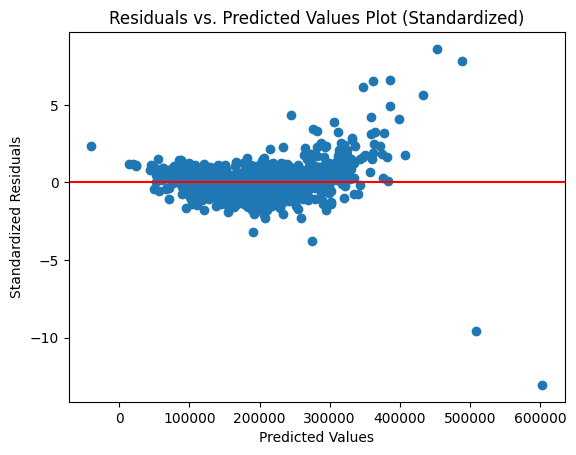

In [30]:
y_pred = grid_search.predict(X)
residuals = y - y_pred

# Standardize residuals
residuals_standardized = residuals / residuals.std()

# Residuals vs. Predicted Values Plot
plt.scatter(y_pred, residuals_standardized)
plt.xlabel("Predicted Values")
plt.ylabel("Standardized Residuals")
plt.title("Residuals vs. Predicted Values Plot (Standardized)")
plt.axhline(y=0, color='r', linestyle='-')  # Adding a line at y=0
plt.show()

From the graph it appears that the residues are following some systematic pattern, which is not good. This suggests the presence of heteroscedasticity, that is, variances that are not constant over time. Outliers can also contribute to heteroscedasticity.


Now, let's check to the normality of errors.

The residuals do not follow a normal distribution.


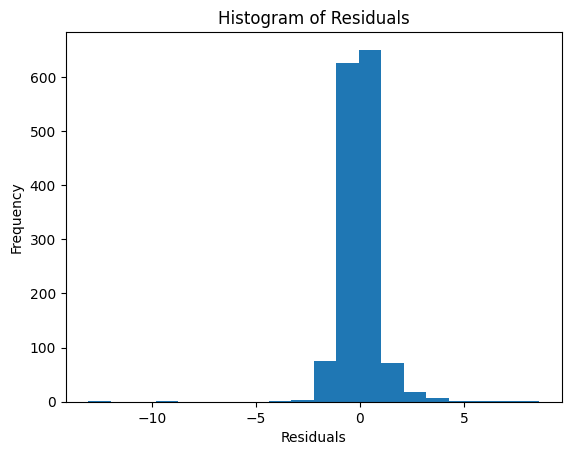

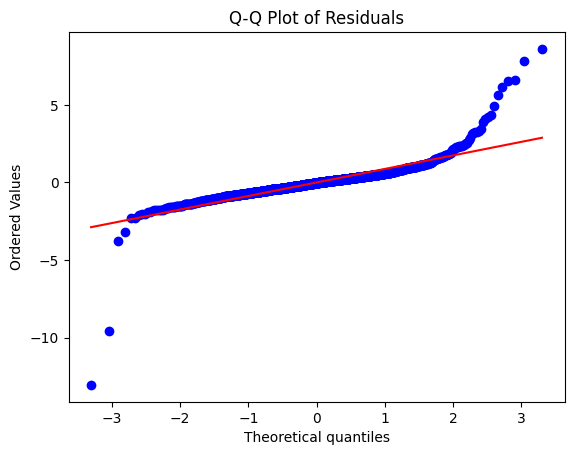

In [32]:
# Checking for Normality of Errors
# Example using the Shapiro-Wilk test
_, p_value_sw = stats.shapiro(residuals_standardized)
if p_value_sw > 0.05:
    print("The residuals follow a normal distribution.")
else:
    print("The residuals do not follow a normal distribution.")

# Histogram of Residuals
plt.hist(residuals_standardized, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# Q-Q Plot of Residuals
stats.probplot(residuals_standardized, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Whenever we run a model or perform data analysis, it is common to check the distribution of the variables in question. If some are skewed and not normally distributed, we tend to worry. The truth is that the need to assume normality for independent and dependent variables is not always true.

**The variable that should be normally distributed is just the prediction error!**

The prediction error must follow a normal distribution with mean 0. The calculation of the confidence interval and the significance of the variable is based on this assumption.

You can also use the Shapiro-Wilk test to test the normality assumption. Basically, if the p-value is greater than the threshold (usually 0.05) then we accept the distribution as normal.

How do we fix the normality problem? Typically, there are 2 reasons why this problem occurs:

* Dependent or independent variables are very abnormal (you can see by the asymmetry and/or kurtosis of the variable)
* Existence of some outliers that hinder the model’s prediction

We must then check for outliers in the variables and if this does not solve the problem, we must transform some variables that are not normally distributed so that they are normally distributed.

In conclusion, if you try to find a significant predictive factor or define the confidence interval, remember to check the distribution of the error term after building the model. If the dependent variables or independent variables are very non-normal, one can use the box-cox transformation (for example) to transform it and make the error term more normally distributed.

In our case, neither homoscedaticity or the normal distribution of errors were met, which compromises our analysis. In your projects you must fix this, as this work is only at a didactic level, we will not delve into this issue further. One idea to fix this would perhaps be to normalize the target variable.

## Evaluate the model globally

Linear regression models are intrinsically explainable, which means that if we understand how the model works, then we can make sense of their predictions.

Let's now try to interpret the model globally. For this we need to determine:

- Coefficient magnitude and sign
- Coefficient significance (t statistic and p-value)
- Effects plot

Determine the coefficient's error using cross-validation.

In [10]:
# Função para ajustar o modelo com GridSearchCV e retornar os coeficientes
def fit_model_and_get_coeffs(X_train, y_train, param_grid):
    grid_search_globally = GridSearchCV(final_model, param_grid, cv=5, scoring='r2', return_train_score=True)
    grid_search_globally.fit(X_train, y_train)
    return grid_search_globally.best_estimator_.named_steps.regressor.coef_, grid_search_globally.best_estimator_.named_steps.preprocessor.get_feature_names_out()

# Número de iterações Bootstrap
num_bootstrap_iterations = 100

# Lista para armazenar os coeficientes de cada iteração Bootstrap
coeffs_bootstrap = []

# Inicializar lista de nomes de coeficientes
coeffs_names = []

# Loop sobre cada iteração Bootstrap
for i in range(num_bootstrap_iterations):
    # Amostragem aleatória com substituição dos índices
    indices = np.random.choice(range(len(X)), size=len(X), replace=True)
    X_bootstrap, y_bootstrap = X.iloc[indices], y.iloc[indices]
    
    # Dividir o conjunto de dados amostrado em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2, random_state=42)
    
    # Ajuste do modelo e obtenção dos coeficientes para esta amostra
    coeffs_boot, new_coeffs_names = fit_model_and_get_coeffs(X_train, y_train, param_grid)
    
    # Adicionar os nomes de coeficientes únicos
    coeffs_names.extend([name for name in new_coeffs_names if name not in coeffs_names])
    
    # Adicionar os coeficientes desta iteração Bootstrap à lista
    coeffs_bootstrap.append(coeffs_boot)
    
# Determinar o tamanho máximo do array de coeficientes
max_coeffs_length = max(len(coeffs) for coeffs in coeffs_bootstrap)

# Preencher os arrays de coeficientes com zeros para que todos tenham o mesmo tamanho
coeffs_bootstrap_padded = [np.pad(coeffs, (0, max_coeffs_length - len(coeffs)), mode='constant') for coeffs in coeffs_bootstrap]

# Converter a lista de arrays de coeficientes em uma matriz numpy
coeffs_bootstrap = np.vstack(coeffs_bootstrap_padded)

# Garantir que coeffs_names tenha o mesmo comprimento que o número de colunas em coeffs_mean
coeffs_names = coeffs_names[:coeffs_bootstrap.shape[1]]

# Calcular a média dos coeficientes
coeffs_mean = np.mean(coeffs_bootstrap, axis=0)

# Calcular o desvio padrão dos coeficientes
coeffs_std = np.std(coeffs_bootstrap, axis=0)

# Criar um DataFrame para armazenar a média e o desvio padrão dos coeficientes
coeffs_df = pd.DataFrame({'mean_coeffs_sign': coeffs_mean, 'coeffs_std': coeffs_std}, index=coeffs_names).reset_index()
coeffs_df.sort_values(by=['mean_coeffs_sign'], ascending=False, inplace=True)
coeffs_df.rename(columns={'index': 'features'}, inplace=True)

# Visualizar o DataFrame
coeffs_df

,features,mean_coeffs_sign,coeffs_std
12,quantitative_preproc__GrLivArea,22107.030721,5646.329811
2,quantitative_preproc__OverallQual,18835.259056,2457.473041
5,quantitative_preproc__BsmtFinSF1,4940.292780,3699.860516
21,quantitative_preproc__GarageCars,4599.724694,3387.744730
33,quantitative_median_preproc__MasVnrArea,4241.740761,2034.224252
8,quantitative_preproc__TotalBsmtSF,2888.285575,3223.395622
20,quantitative_preproc__Fireplaces,2821.088782,1581.318632
1,quantitative_preproc__LotArea,2685.937678,1699.203401
22,quantitative_preproc__GarageArea,2522.360235,2349.972976
205,ordinal_quality_preproc__HeatingQC,2269.480171,3371.174550


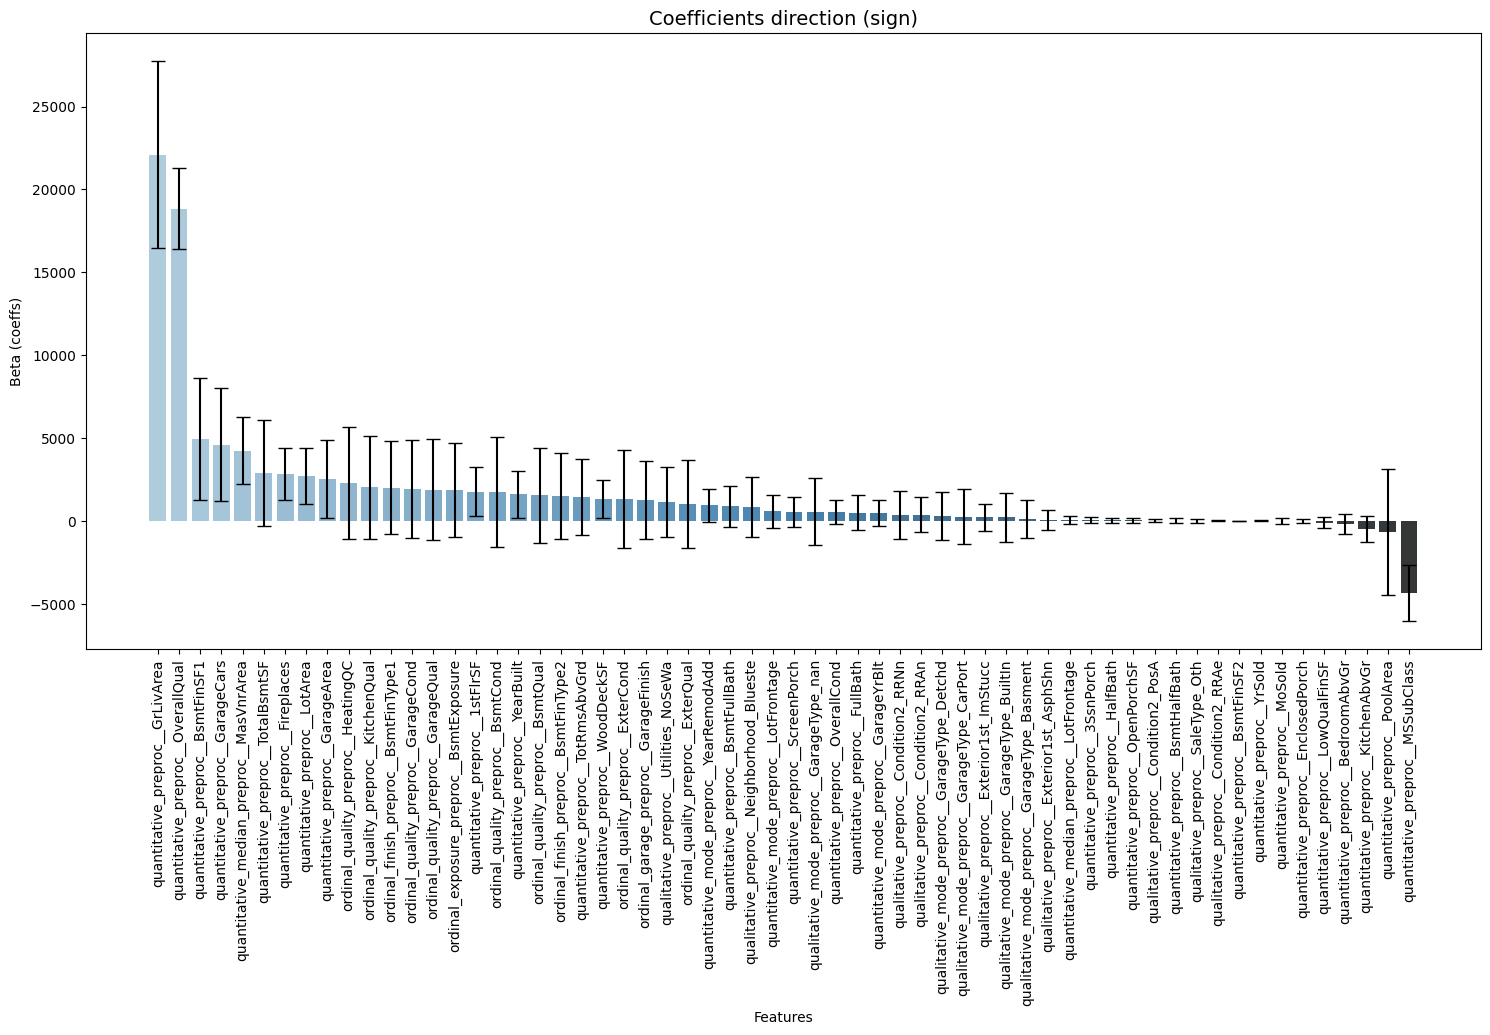

In [11]:
# filter df to not show the coeffs that went to 0
filtered_coeffs = coeffs_df.loc[(coeffs_df['mean_coeffs_sign'] != 0.0) &
                                (coeffs_df['mean_coeffs_sign'] != -0.0)]

# Create a function of the graph to reuse later
def barplot(figsize, title, data, x, y, xlabel, ylabel, error_data=None):
    # Plot the graph
    plt.figure(figsize=figsize)

    # Title
    plt.title(title, fontsize=14)

    # Graph
    sns.barplot(data=data, x=x, y=y, ci=None, palette="Blues_d")

    # Adding error bars if error_data is provided
    if error_data is not None:
        std_err = error_data
        plt.errorbar(data[x], data[y], yerr=std_err, fmt='none', color='k', capsize=5)

    # Label
    plt.xticks(rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Example usage:
barplot((18, 8), 'Coefficients direction (sign)', filtered_coeffs,
        'features', 'mean_coeffs_sign', 'Features', 'Beta (coeffs)',
        error_data=filtered_coeffs['coeffs_std'])

* Beta (coefficients) represents the gradient (slope) of the regression
* Beta is the change in y, per unit change in x (if all the other values stay the same)
* The positive values, if x increases, so does y
* The negative values, if x increases, y decreases 

The Beta related to the feature "GrLivArea" > Beta related to the feature "OverallQuall", in other words "GrLivArea" has a greater contribuition than "OverallQuall" to the target value.

Let's compare the absolute value of each coefficient.

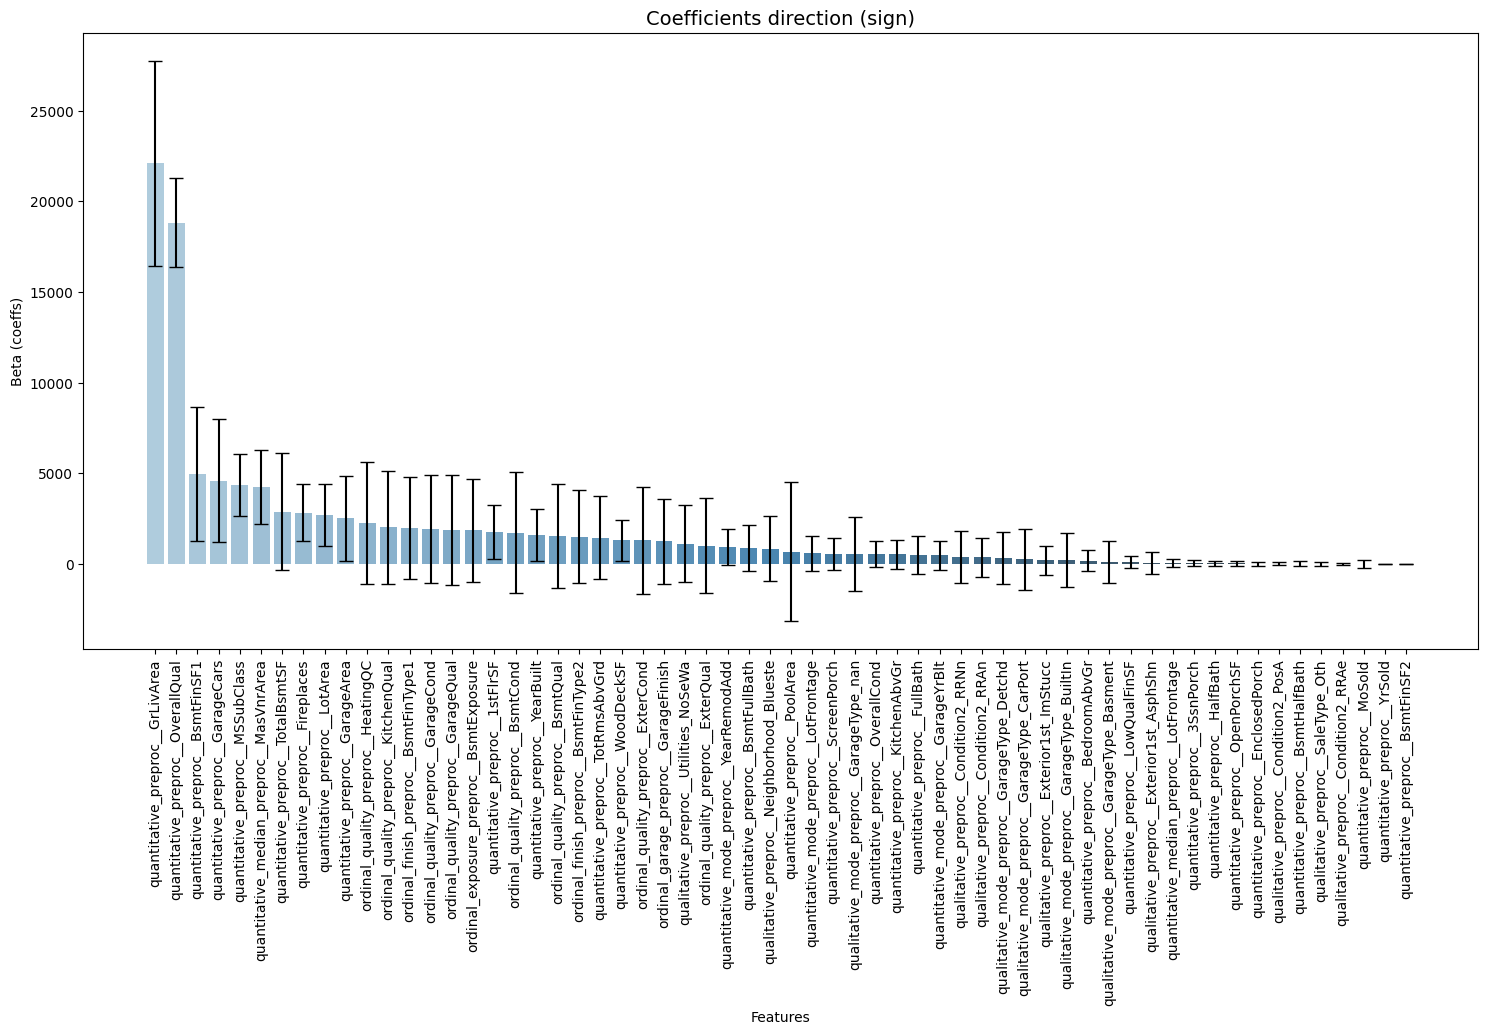

In [12]:
# extract the absolute value of each coeff
filtered_coeffs['mean_coeffs_sign'] = filtered_coeffs['mean_coeffs_sign'].abs()
filtered_coeffs.sort_values(by=['mean_coeffs_sign'], ascending=False, inplace=True)

barplot((18, 8), 'Coefficients direction (sign)', filtered_coeffs, 
        'features', 'mean_coeffs_sign', 
        'Features', 'Beta (coeffs)',
        error_data=filtered_coeffs['coeffs_std'])

This is what we normally use as a value of feature importance (feature selection methods, Lasso model automatically does this for us). Initially with more than 200 features, we ended with these, which are the most important for the model.

### Calculate the t-statistic and p-value for each coefficient

The t-value, also known as the t-test, is an important focus of attention, since it is the link that tells us whether the association between an explanatory variable and the response is statistically significant. The t-value is simply the estimate/standard error, and thus can be interpreted as the distance of the estimate from 0, measured in standard errors. Given a t-value and sample size, the software can provide an accurate p-value; for large samples, t-values ​​greater than 2 or less than –2 correspond to p < 0.05, although these thresholds are higher for smaller sample sizes.

* t-test tests the null hypothesis: b=0
* Tests how big b is, compared to its variability

If t is too big or too small -> the probability that b=0 is small, then, the regression coefficient is statistically significant.


In [13]:
filtered_coeffs['t_test'] = filtered_coeffs['mean_coeffs_sign'] / filtered_coeffs['coeffs_std']
filtered_coeffs

,features,mean_coeffs_sign,coeffs_std,t_test
12,quantitative_preproc__GrLivArea,22107.030721,5646.329811,3.915292
2,quantitative_preproc__OverallQual,18835.259056,2457.473041,7.664482
5,quantitative_preproc__BsmtFinSF1,4940.292780,3699.860516,1.335265
21,quantitative_preproc__GarageCars,4599.724694,3387.744730,1.357754
0,quantitative_preproc__MSSubClass,4356.466154,1688.645019,2.579859
33,quantitative_median_preproc__MasVnrArea,4241.740761,2034.224252,2.085188
8,quantitative_preproc__TotalBsmtSF,2888.285575,3223.395622,0.896038
20,quantitative_preproc__Fireplaces,2821.088782,1581.318632,1.784010
1,quantitative_preproc__LotArea,2685.937678,1699.203401,1.580704
22,quantitative_preproc__GarageArea,2522.360235,2349.972976,1.073357


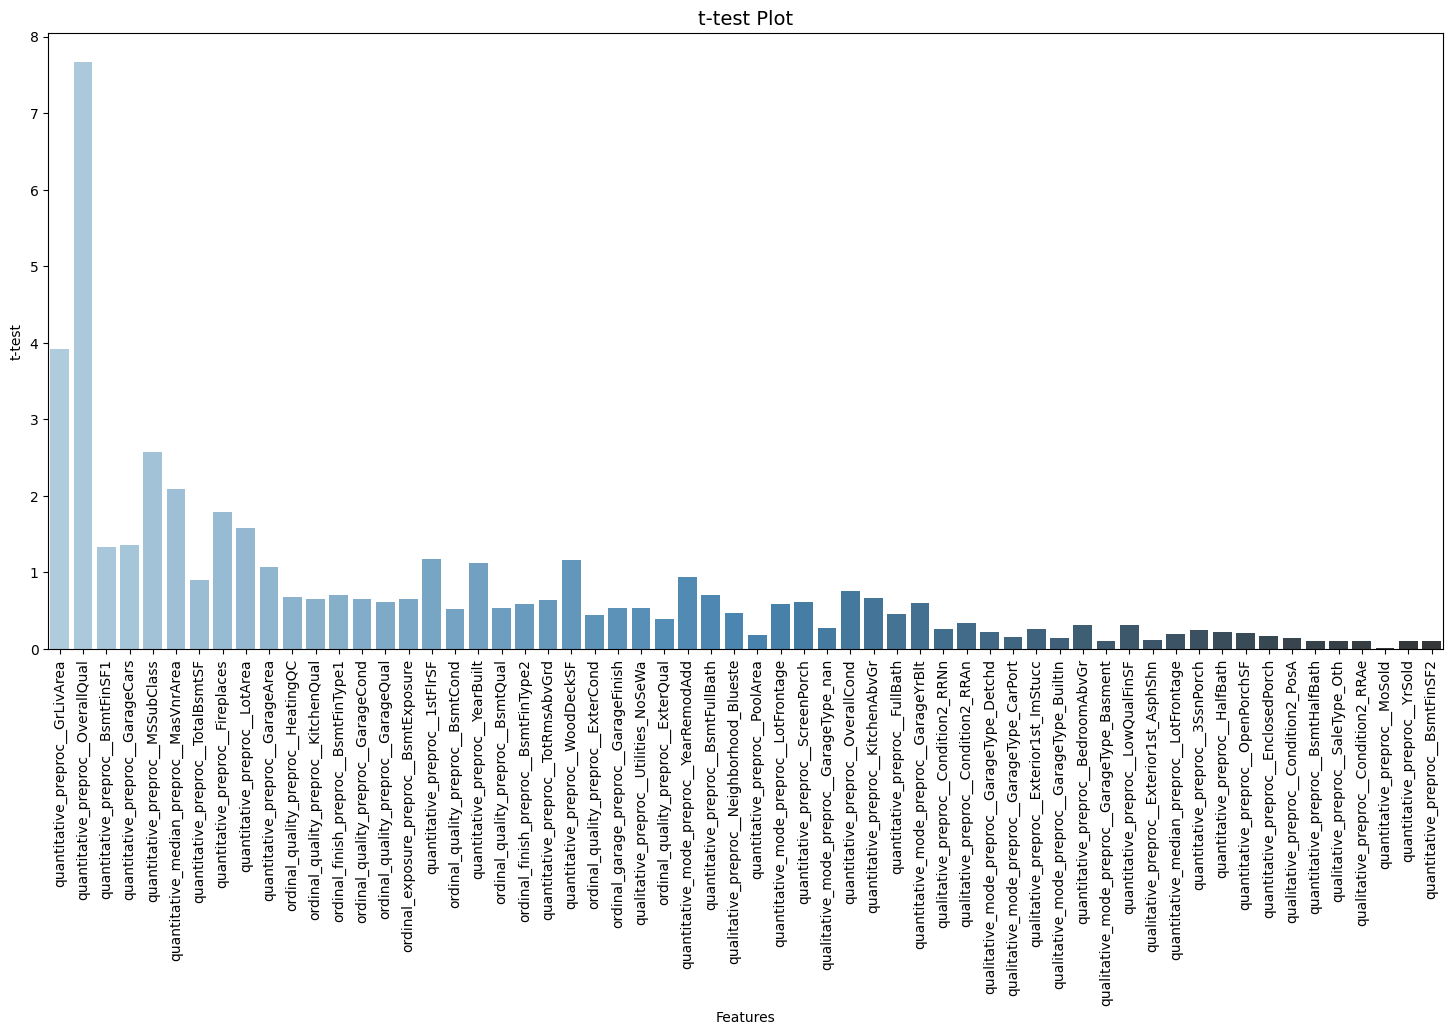

In [14]:
barplot((18, 8), 't-test Plot', filtered_coeffs, 
        'features', 't_test', 
        'Features', 't-test')

Based on the t values, we can, for example, trust the value of the coefficient of variable "OverallQual" more than that of variable "GrLivArea".

### Effect plots

Features whose coefficient is bigger are said to be more important. This coefficients alone don't determine the value of the target, to have this, we need the combination of these coefficients with the value of the variable, the one that contributes to the final target outcome.

So, instead of plot just the coefficients we can plot the effects.

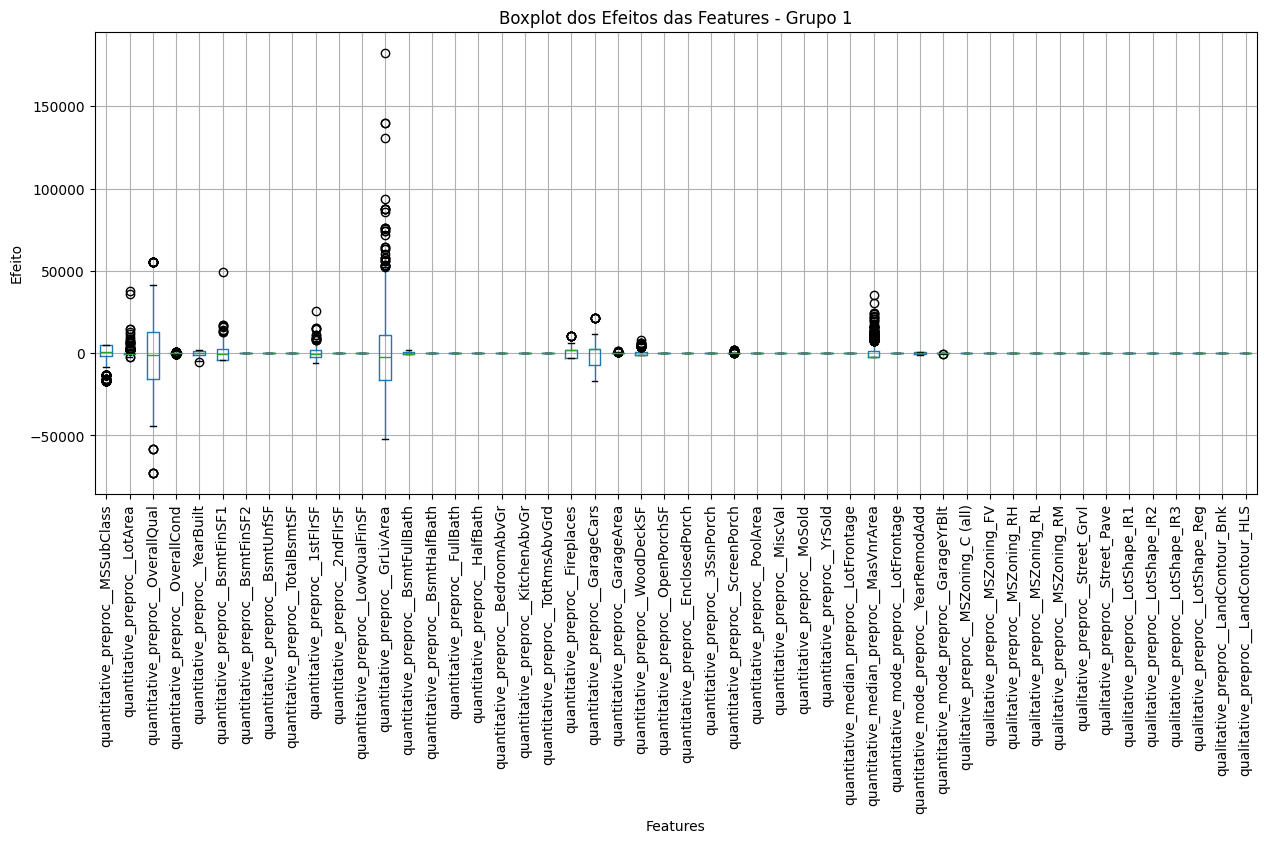

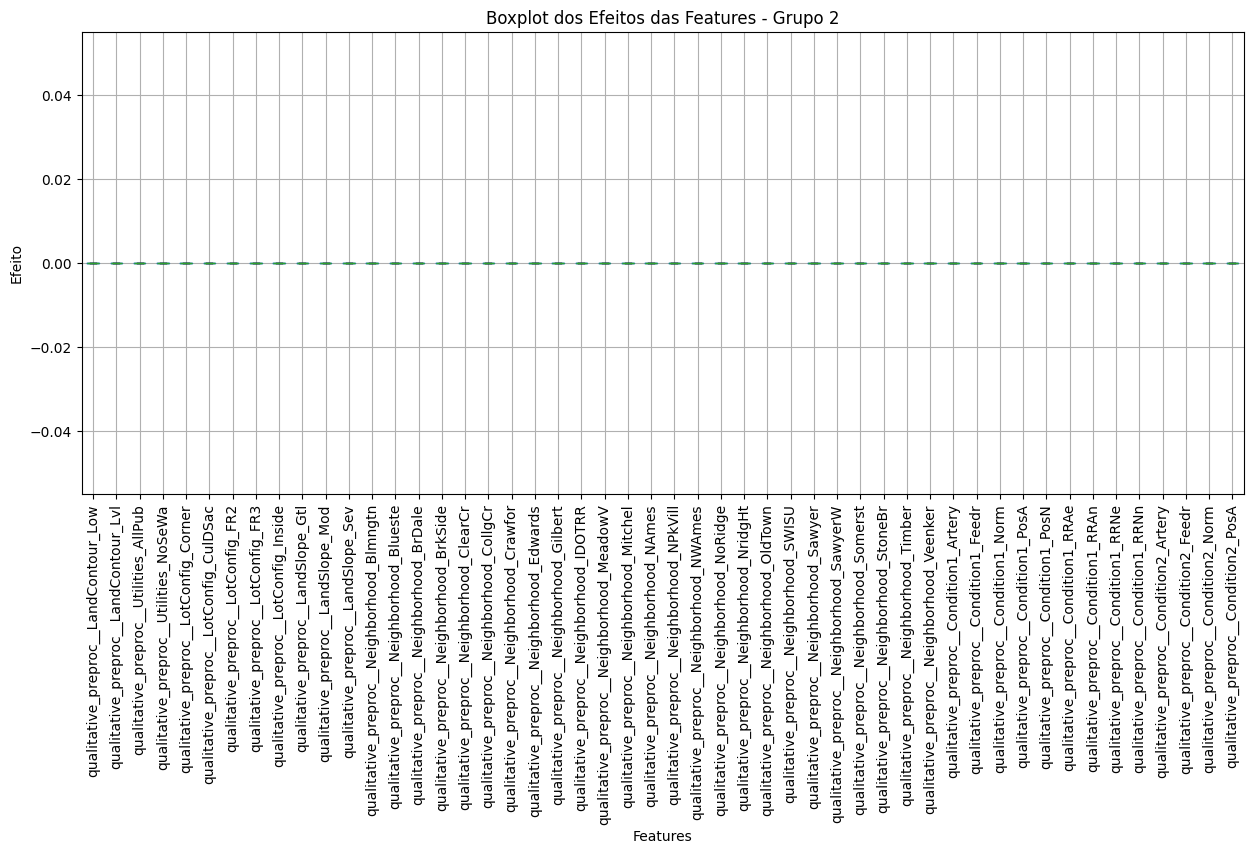

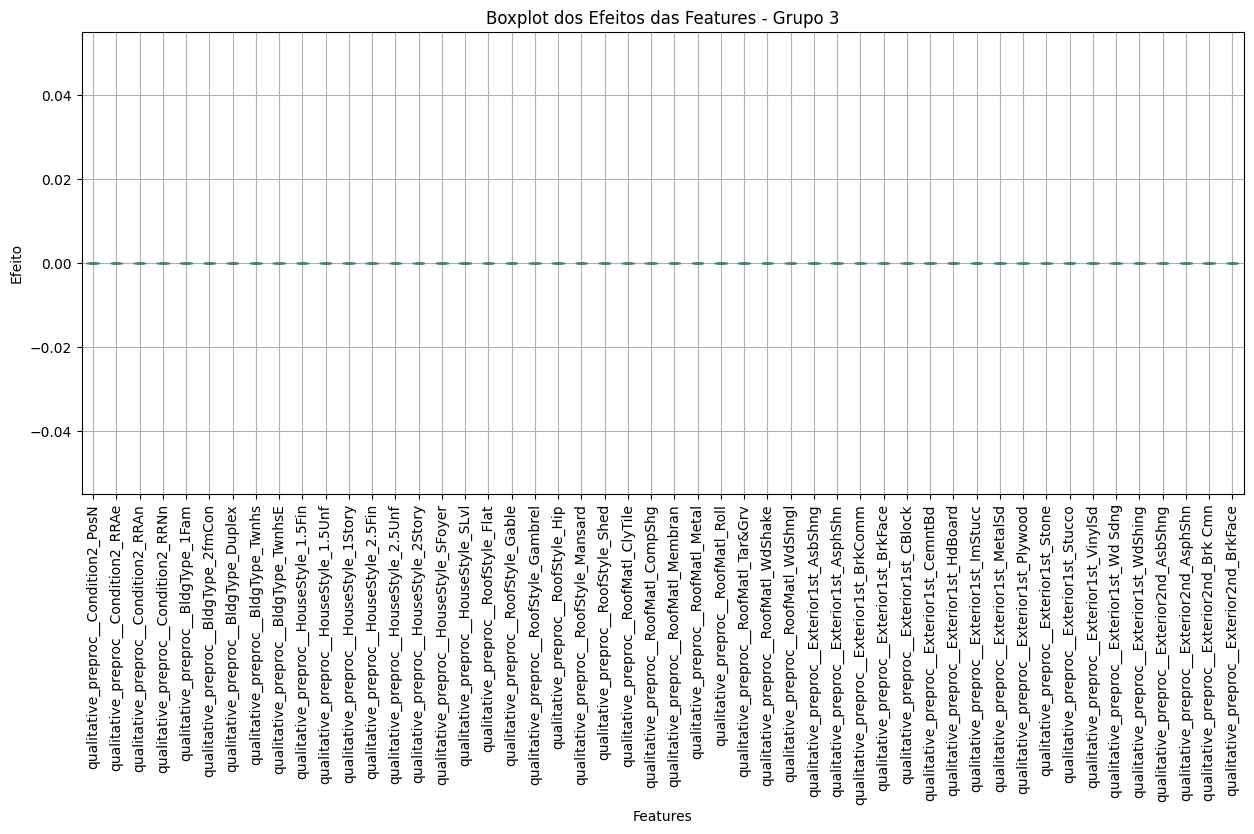

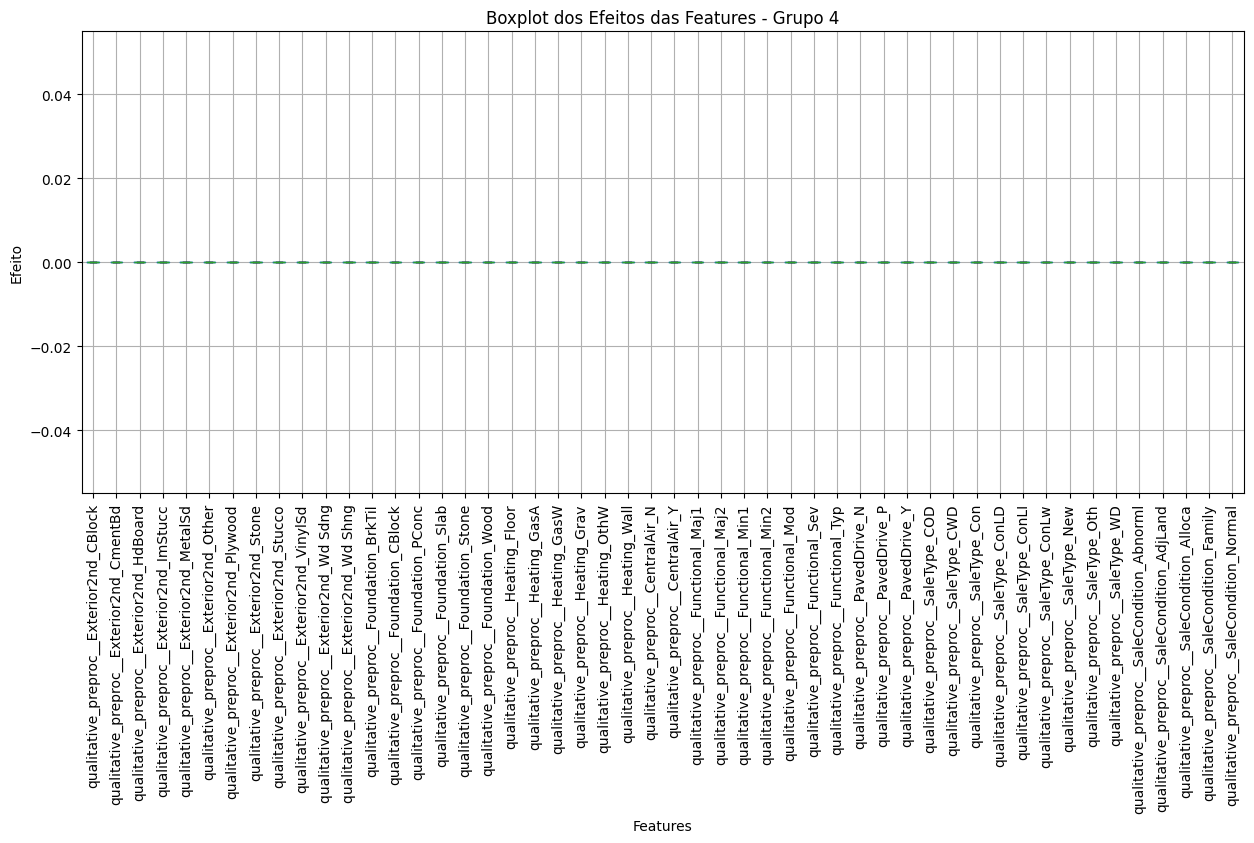

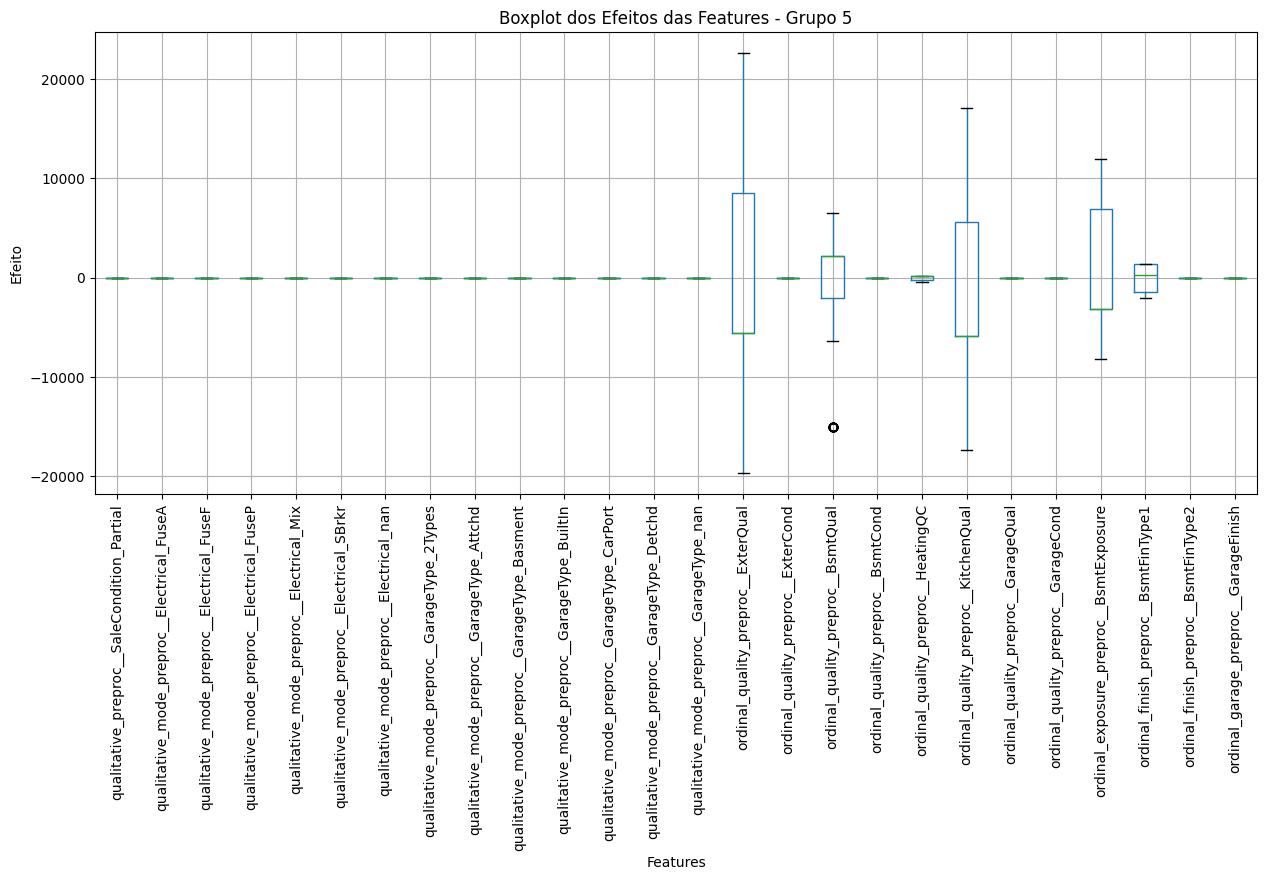

In [15]:
# get the coefficients and the values of the variables
scaler_names = grid_search.best_estimator_.named_steps.preprocessor.get_feature_names_out()
final_coeffs = grid_search.best_estimator_.named_steps.regressor.coef_
X_train_transformed = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_train)

# calculate the effects
effects = final_coeffs * X_train_transformed

# dividing the variables in groups of 50
num_variables = len(scaler_names)
group_size = 50
num_groups = int(np.ceil(num_variables / group_size))

# iterate for the variables groups
for i in range(num_groups):
    start_index = i * group_size
    end_index = min((i + 1) * group_size, num_variables)
    
    # select the variables for the actual group
    scaler_names_group = scaler_names[start_index:end_index]
    effects_group = effects[:, start_index:end_index]
    
    # create the dataframe for the actual group
    effects_df_group = pd.DataFrame(effects_group, columns=scaler_names_group)
    
    # plot the boxplot for the actual group
    plt.figure(figsize=(15, 6))
    effects_df_group.boxplot()
    plt.title(f'Boxplot of Features Effects - Group {i+1}')
    plt.ylabel('Effects (Coefficient x Feature Value)')
    plt.xlabel('Features')
    plt.xticks(rotation=90)
    plt.show()

As we can see, the main drivers of the house price are the variables "OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "BsmtExposure".

## Local interpretability

The same interpretation that we did globally (for all instances) we can also do locally for just one instance if you are interested in a specific case.

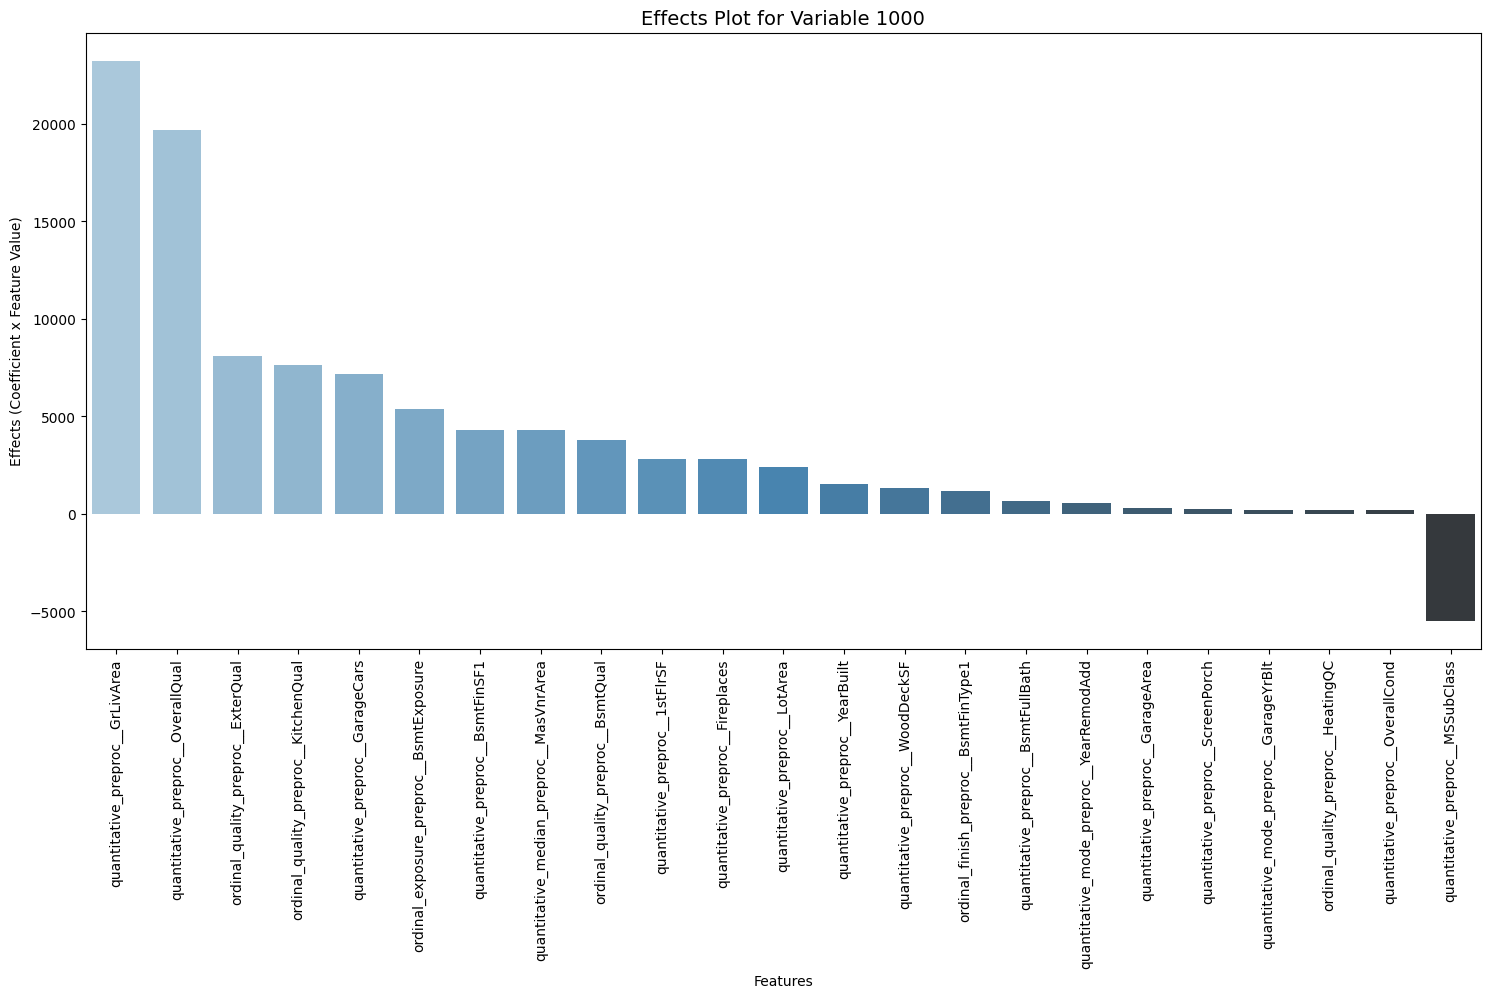

In [21]:
# calculate the effects of instance 1000
effects1000 = final_coeffs * X_train_transformed[1000]

# create the dataframe for the instance 1000
effects_df1000 = pd.DataFrame({'mean_coeffs_sign': final_coeffs}, index=scaler_names).reset_index()
effects_df1000.sort_values(by=['mean_coeffs_sign'], ascending=False, inplace=True)
effects_df1000.rename(columns={'index': 'features'}, inplace=True)
effects_df1000 = effects_df1000.loc[
    (effects_df1000['mean_coeffs_sign'] != 0.0) &
    (effects_df1000['mean_coeffs_sign'] != -0.0)]

# plot the bar graph
barplot((18, 8), 'Effects Plot for Variable 1000', effects_df1000, 
        'features', 'mean_coeffs_sign', 
        'Features', 'Effects (Coefficient x Feature Value)')

As we can see, these are the effects of the most important variables on the final price of the index house equal to 1000.

## Conclusion

Here I want to summarize the main advandages of the linear regression models and also some of the limitations.

Advantages:

* Predict the target as a linear combination of the predictors (weighted sum of the predictors) and as humans we are very good interpreting linear models.
* We can use statistical tests to decide if / how much we can trust the model and its parameters (βi)
* Intrinsically explainable by design
* We can use regularization to reduce the feature space
    * Optimize for interpretability

Limitations:

* The interpretation of the weight / coefficient is contrastive (depends on all other features)
    * Features with positive correlation coefficient show a negative weight
* Make assumptions on the data -> when they are not met, we can’t trust the model
* Multicolinearity affects interpretability
* Interactions between the variables won’t be captured

Credits:

https://www.trainindata.com/
